# Multi-agent network

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create a specialized agent for each task or domain and route tasks to the correct "expert". This is an example of a multi-agent network architecture.

The resulting graph will look something like the following diagram:



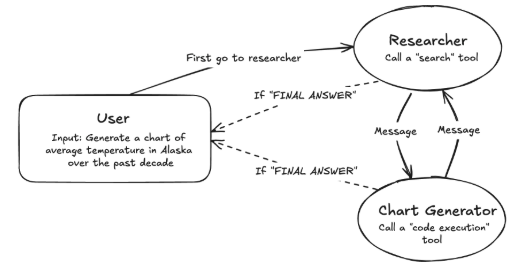

## Setup

First, let's install our required packages and set our API keys:

In [1]:
!pip install -U langchain_community langchain_openai langchain_experimental langgraph \
matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing 

In [1]:
import getpass
import os

def _set_if_undefined(var: str):
  if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

Please provide your OPENAI_API_KEY··········
Please provide your TAVILY_API_KEY··········


## Define tools

We will also define some tools that our agents will use in the future

In [4]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

/tmp/ipython-input-2185858283.py:7: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define Agent Nodes

We now need to define the nodes.

First, we'll create a utility to create a system prompt for each agent.

In [5]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [6]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

llm = ChatOpenAI(model="gpt-4.1", temperature=0)

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### Define the Graph

We can now put it all together and define the graph!

In [7]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

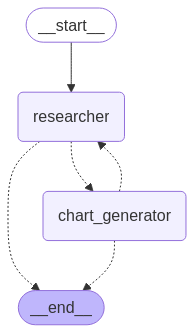

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='49a1ac2c-1f55-4b5e-9383-179d072fab4b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mn16eVRTs2dMdkrXH8GExrQF', 'function': {'arguments': '{"query":"UK GDP data for the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 208, 'total_tokens': 234, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_3502f4eb73', 'id': 'chatcmpl-CO5cd2RUM31OM3vIMQlBPWJLGqTxT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs'

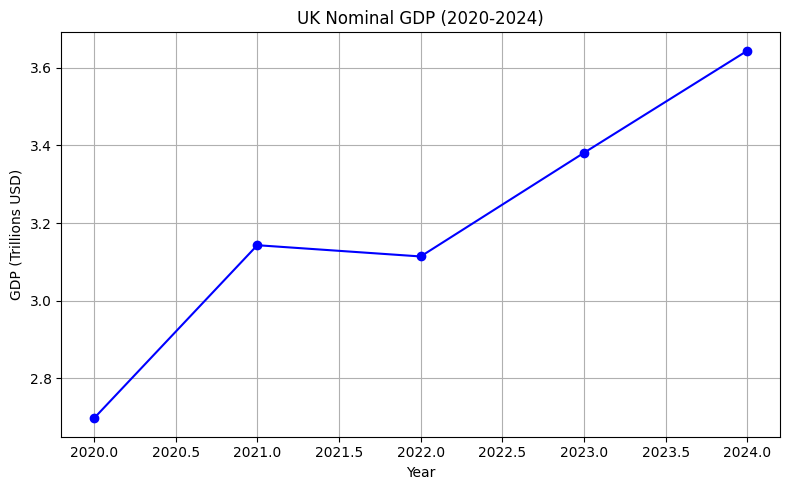

{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='49a1ac2c-1f55-4b5e-9383-179d072fab4b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mn16eVRTs2dMdkrXH8GExrQF', 'function': {'arguments': '{"query":"UK GDP data for the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 208, 'total_tokens': 234, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_3502f4eb73', 'id': 'chatcmpl-CO5cd2RUM31OM3vIMQlBPWJLGqTxT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logp

In [ ]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")